In [ ]:
!pip install --upgrade azureml-core

In [ ]:
!pip install --upgrade scikit-learn==0.24.2

In [ ]:
!pip install --upgrade imbalanced-learn==0.8.0

In [ ]:
!pip install --upgrade seaborn

In [ ]:
!pip install azureml-interpret

In [ ]:
!pip install interpret-community[visualization]

In [1]:
import azureml.core


print(f"Azure ML SDK Version: {azureml.core.VERSION}")

Azure ML SDK Version: 1.30.0


In [2]:
from azureml.core import Workspace


ws = Workspace.from_config()
ws

Workspace.create(name='sandboxaml', subscription_id='f80606e5-788f-4dc3-a9ea-2eb9a7836082', resource_group='rg-sandbox')

In [3]:
import sklearn


print(f"Azure ML SDK Version: {sklearn.__version__}")

Azure ML SDK Version: 0.24.2


In [4]:
experiment_name = 'exp_german_credit'

In [5]:
from azureml.core import Experiment


exp = Experiment(workspace=ws, name=experiment_name)
exp

Name,Workspace,Report Page,Docs Page
exp_german_credit,sandboxaml,Link to Azure Machine Learning studio,Link to Documentation


In [ ]:
import pandas as pd

df=pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data",sep=" ",header=None)

In [ ]:
headers=["Status of existing checking account","Duration in month","Credit history",\
         "Purpose","Credit amount","Savings account/bonds","Present employment since",\
         "Installment rate in percentage of disposable income","Personal status and sex",\
         "Other debtors / guarantors","Present residence since","Property","Age in years",\
        "Other installment plans","Housing","Number of existing credits at this bank",\
        "Job","Number of people being liable to provide maintenance for","Telephone","foreign worker","Cost Matrix(Risk)"]
df.columns=headers

In [6]:
dataset_name = 'German Credit'

In [7]:
from azureml.core import Dataset


dataset = Dataset.get_by_name(ws, name=dataset_name)
df = dataset.to_pandas_dataframe()

In [8]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix,  plot_roc_curve, f1_score, recall_score
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE
import json
import mlflow
import mlflow.sklearn

In [9]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


In [10]:
df.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')

In [11]:
df.dtypes

checking_status           object
duration                   int64
credit_history            object
purpose                   object
credit_amount              int64
savings_status            object
employment                object
installment_commitment     int64
personal_status           object
other_parties             object
residence_since            int64
property_magnitude        object
age                        int64
other_payment_plans       object
housing                   object
existing_credits           int64
job                       object
num_dependents             int64
own_telephone             object
foreign_worker            object
class                     object
dtype: object

In [12]:
df.iloc[1,:]

checking_status                     0<=X<200
duration                                  48
credit_history                 existing paid
purpose                             radio/tv
credit_amount                           5951
savings_status                          <100
employment                            1<=X<4
installment_commitment                     2
personal_status           female div/dep/mar
other_parties                           none
residence_since                            2
property_magnitude               real estate
age                                       22
other_payment_plans                     none
housing                                  own
existing_credits                           1
job                                  skilled
num_dependents                             1
own_telephone                           none
foreign_worker                           yes
class                                    bad
Name: 1, dtype: object

# Visualizations

In [13]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [14]:
print(df.duration.value_counts())

24    184
12    179
18    113
36     83
6      75
15     64
9      49
48     48
30     40
21     30
10     28
27     13
60     13
42     11
11      9
20      8
8       7
4       6
39      5
45      5
7       5
14      4
13      4
33      3
28      3
22      2
16      2
54      2
26      1
40      1
47      1
5       1
72      1
Name: duration, dtype: int64


In [15]:
print(df["class"].value_counts())

good    700
bad     300
Name: class, dtype: int64


In [16]:
print(df[["duration", "credit_amount", "age"]].describe())

          duration  credit_amount          age
count  1000.000000    1000.000000  1000.000000
mean     20.903000    3271.258000    35.546000
std      12.058814    2822.736876    11.375469
min       4.000000     250.000000    19.000000
25%      12.000000    1365.500000    27.000000
50%      18.000000    2319.500000    33.000000
75%      24.000000    3972.250000    42.000000
max      72.000000   18424.000000    75.000000


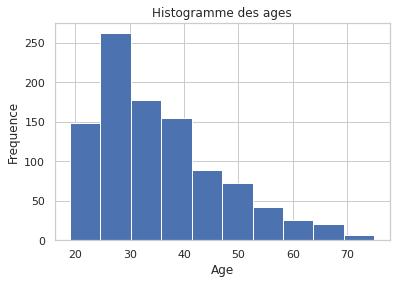

In [17]:
df["id"] = range(0, 1000)
df.age.hist()
plt.title('Histogramme des ages')
plt.xlabel('Age')
plt.ylabel('Frequence')
plt.savefig('hist_age')

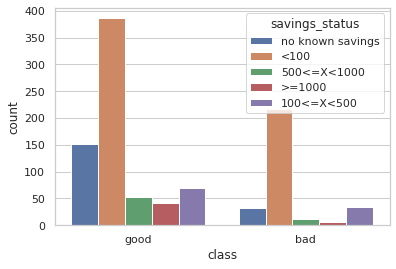

In [18]:
sns.countplot(x="class", hue="savings_status", data=df)

In [ ]:
sns.countplot(x="class", hue="employment", data=df)

In [ ]:
sns.hisplot(x="age", hue="class", data=df)
# Retirer la légende pour counplot
#https://www.delftstack.com/howto/seaborn/remove-legend-seaborn-plot/
# ou faire un histplot
# module 'seaborn' has no attribute 'hisplot'

In [ ]:
sns.countplot(x="class", hue="housing", data=df)

In [ ]:
sns.countplot(x="class", hue="foreign_worker", data=df)

In [ ]:
sns.countplot(x="class", hue="job", data=df)

In [ ]:
sns.countplot(x="class", hue="property_magnitude", data=df)

In [ ]:
sns.countplot(x="class", hue="residence_since", data=df)  # mauvaise representation

In [ ]:
sns.countplot(x="class", hue="other_parties", data=df)

# Train model

In [19]:
# d'où vient la variable id ? du dataset Azure ML ?
df.drop("id", axis=1, inplace=True)

In [20]:
df["class"] = [1 if x == "good" else 0 for x in df["class"]]

In [21]:
print(df["class"].value_counts())

1    700
0    300
Name: class, dtype: int64


In [22]:
df.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')

In [23]:
credit_train, credit_test = train_test_split(df, test_size=0.2)
Y_train = credit_train["class"]
credit_train.drop("class", axis=1, inplace=True)

Y_test = credit_test["class"]
credit_test.drop("class", axis=1, inplace=True)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [24]:
le = preprocessing.LabelEncoder()
X_train = pd.DataFrame()
X_test = pd.DataFrame()

for c in credit_train:
    X_train[c] = le.fit_transform(credit_train[c])
    X_test[c] = le.fit_transform(credit_test[c])

In [25]:
X_train.shape

(800, 20)

In [26]:
X_train.iloc[1,:]

checking_status             1
duration                    8
credit_history              3
purpose                     3
credit_amount             241
savings_status              2
employment                  0
installment_commitment      1
personal_status             0
other_parties               0
residence_since             2
property_magnitude          1
age                        11
other_payment_plans         1
housing                     1
existing_credits            0
job                         1
num_dependents              0
own_telephone               0
foreign_worker              1
Name: 1, dtype: int64

In [27]:
X_train.dtypes

checking_status           int64
duration                  int64
credit_history            int64
purpose                   int64
credit_amount             int64
savings_status            int64
employment                int64
installment_commitment    int64
personal_status           int64
other_parties             int64
residence_since           int64
property_magnitude        int64
age                       int64
other_payment_plans       int64
housing                   int64
existing_credits          int64
job                       int64
num_dependents            int64
own_telephone             int64
foreign_worker            int64
dtype: object

In [28]:
# Basic logistic regression

model = LogisticRegression(penalty='l2', max_iter=10000).fit(X=X_train, y=Y_train)
print("Train accuracy : {}".format(model.score(X_train, Y_train)))
print("Test accuracy : {}".format(model.score(X_test, Y_test)))

Train accuracy : 0.745
Test accuracy : 0.72


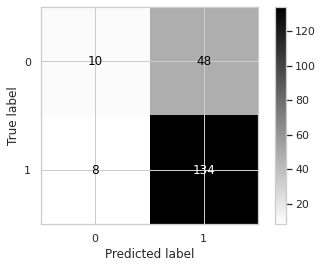

In [29]:
plot_confusion_matrix(model, X_test, Y_test, cmap="binary")

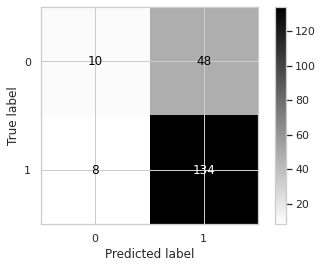

In [30]:
cm_image = plot_confusion_matrix(model, X_test, Y_test, cmap="binary")

In [31]:
cm_image.savefig("confusionmatrix.png")

AttributeError: 'ConfusionMatrixDisplay' object has no attribute 'savefig'

In [ ]:
print("Recall : {}".format(recall_score(model.predict(X_test), Y_test)))
print("F1 : {}".format(f1_score(model.predict(X_test), Y_test)))

In [ ]:
plot_roc_curve(model, X_test, Y_test)
plt.show()

# Oversampling

In [ ]:
oversample = BorderlineSMOTE()
X_train_os, Y_train_os = oversample.fit_resample(X_train, Y_train)
print(Counter(Y_train_os))

model = LogisticRegression(penalty='l2', max_iter=10000).fit(X=X_train_os, y=Y_train_os)

print("F1 oversampled borderline: {}".format(f1_score(model.predict(X_test), Y_test)))

In [ ]:
oversample = SVMSMOTE()
X_train_os, Y_train_os = oversample.fit_resample(X_train, Y_train)
print(Counter(Y_train_os))

model = LogisticRegression(penalty='l2', max_iter=10000).fit(X=X_train_os, y=Y_train_os)

print("F1 oversampled SVM: {}".format(f1_score(model.predict(X_test), Y_test)))

### Register the model

In [ ]:
model_name = 'german_credit_log_model.pkl'
model_path = 'models/' + model_name

In [ ]:
import joblib
import pickle


os.makedirs('models', exist_ok=True)

# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=model, filename=model_path)

In [ ]:
model = joblib.load(model_path)

raw_data = json.dumps({ 
    'data': [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        #,['0<=X<200',24,'existing paid','radio/tv',5951,'<100','1<=X<4',2,'female div/dep/mar','none',2,'real estate',22,'none','own',1,'skilled',1,'none','yes']
    ]
    ,'method': 'predict'  # If you have a classification model, you can get probabilities by changing this to 'predict_proba'.
})

data = json.loads(raw_data)['data']
method = json.loads(raw_data)['method']
print(method)

result = model.predict(data)
proba = model.predict_proba(data)

print(result.tolist())
print(proba.tolist())

In [ ]:
from azureml.core.model import Model


model = Model.register(workspace=ws,
                       model_name=model_name,
                       model_path=model_path,
                       model_framework=Model.Framework.SCIKITLEARN,  # Framework used to create the model.
                       model_framework_version=sklearn.__version__,             # Version of scikit-learn used to create the model.
                       tags={'dataset': "german credit", 'type': "logistic regression"},
                       description="Logisitc regression model for credit risk"
                       )

In [ ]:
print('Model name:', model.name)
print('Version:', model.version)

In [ ]:
input_dataset = Dataset.get_by_name(ws, name=dataset_name).drop_columns("class")
output_dataset = Dataset.get_by_name(ws, name=dataset_name).keep_columns("class", validate=False)

In [ ]:
from azureml.core.model import Model

model = Model.register(workspace=ws,
                       model_name=model_name,
                       model_path=model_path,
                       model_framework=Model.Framework.SCIKITLEARN,  # Framework used to create the model.
                       model_framework_version=sklearn.__version__,  # Version of scikit-learn used to create the model.
                       sample_input_dataset=input_dataset,
                       sample_output_dataset=output_dataset,
                       tags={'dataset': "german credit", 'type': "logistic regression"},
                       description="Logisitc regression model for credit risk"
                       )

In [ ]:
print('Model name:', model.name)
print('Version:', model.version)
print('Path:', model.get_model_path)

https://docs.microsoft.com/en-us/azure/machine-learning/data-science-virtual-machine/media/how-to-track-experiments/mlflow-diagram-track.png

In [ ]:
%%writefile score.py

import joblib
import numpy as np
import os
import json
import sklearn

from inference_schema.schema_decorators import input_schema, output_schema
from inference_schema.parameter_types.numpy_parameter_type import NumpyParameterType


# The init() method is called once, when the web service starts up.
#
# Typically you would deserialize the model file, as shown here using joblib,
# and store it in a global variable so your run() method can access it later.
def init():
    global model

    # The AZUREML_MODEL_DIR environment variable indicates
    # a directory containing the model file you registered.
    model_filename = 'german_credit_log_model.pkl'
    model_path = os.path.join(os.environ['AZUREML_MODEL_DIR'], model_filename)
    #ModuleNotFoundError: No module named 'sklearn.externals.joblib'
    model = joblib.load(model_path)


# The run() method is called each time a request is made to the scoring API.
#
# Shown here are the optional input_schema and output_schema decorators
# from the inference-schema pip package. Using these decorators on your
# run() method parses and validates the incoming payload against
# the example input you provide here. This will also generate a Swagger
# API document for your web service.
#@input_schema('data', NumpyParameterType(np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])))
#@output_schema(NumpyParameterType(np.array([0])))

def run(raw_data):
    data = json.loads(raw_data)['data']
    method = json.loads(raw_data)['method']
    # Use the model object loaded by init().
    result = model.predict(data) if method=="predict" else model.predict_proba(data)

    # You can return any JSON-serializable object.
    return result.tolist()

In [ ]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies


environment = Environment('german-credit-deploy-env')
environment.python.conda_dependencies = CondaDependencies.create(pip_packages=[
    'azureml-defaults',
    'inference-schema[numpy-support]',
    'joblib',
    'numpy',
    'sklearn'
])

environment.save_to_directory('environment/env.yml', overwrite=True)



In [ ]:
%%writefile env.yml

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-defaults
  - inference-schema[numpy-support]
  - joblib
  - numpy
  - sklearn
channels:
- anaconda
- conda-forge


In [ ]:
from azureml.core.model import InferenceConfig


inference_config = InferenceConfig(entry_script='score.py', environment=environment)

In [ ]:
service_name = 'german-credit-custom-srv'

In [ ]:
from azureml.core import Webservice
from azureml.core.webservice import AciWebservice
from azureml.exceptions import WebserviceException


# Remove any existing service under the same name.
try:
    Webservice(ws, service_name).delete()
except WebserviceException:
    pass

aci_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1, auth_enabled=False)

service = Model.deploy(workspace=ws,
                       name=service_name,
                       models=[model],
                       inference_config=inference_config,
                       deployment_config=aci_config)

service.wait_for_deployment(show_output=True)

In [ ]:
print(service.state)

In [ ]:
print(service.get_logs())

In [ ]:
# Seulement si auth_enabled=True
print(service.get_keys())

In [ ]:
print(service.swagger_uri)

In [ ]:
import json


input_payload = json.dumps({ 
    "data": [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        #,['0<=X<200',24,'existing paid','radio/tv',5951,'<100','1<=X<4',2,'female div/dep/mar','none',2,'real estate',22,'none','own',1,'skilled',1,'none','yes']
    ],
    "method": "predict"  # If you have a classification model, you can get probabilities by changing this to 'predict_proba'.
})

output = service.run(input_payload)

print(output)


In [ ]:
import json


input_payload = json.dumps({ 
    "data": [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        #,['0<=X<200',24,'existing paid','radio/tv',5951,'<100','1<=X<4',2,'female div/dep/mar','none',2,'real estate',22,'none','own',1,'skilled',1,'none','yes']
    ],
    "method": "predict_proba"  # If you have a classification model, you can get probabilities by changing this to 'predict_proba'.
})

output = service.run(input_payload)

print(output)


In [ ]:
import requests


#input_data = "{\"data\": [[\"0<=X<200\",48,\"existing paid\",\"radio/tv\",5951,\"<100\",\"1<=X<4\",2,\"female div/dep/mar\",\"none\",2,\"real estate\",22,\"none\",\"own\",1,\"skilled\",1,\"none\",\"yes\"]]}"
input_data = "{\"data\": [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]}"

headers = {'Content-Type':'application/json'}

# for AKS deployment you'd need to the service key in the header as well
api_key = service.get_keys()[0]
headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
print("prediction:", resp.text)

In [ ]:
#service.delete()

# Interpretability

https://github.com/MicrosoftDocs/azure-docs/blob/master/articles/machine-learning/how-to-machine-learning-interpretability-aml.md

#### local run

In [ ]:
model = joblib.load(model_path)

In [ ]:
#classes

In [ ]:
#features_names

In [ ]:
from interpret.ext.blackbox import TabularExplainer


# "features" and "classes" fields are optional
explainer = TabularExplainer(model, 
                             X_train, 
                             #features=breast_cancer_data.feature_names, 
                             #classes=classes
                            )

In [ ]:
from interpret.ext.blackbox import MimicExplainer

# you can use one of the following four interpretable models as a global surrogate to the black box model

from interpret.ext.glassbox import LGBMExplainableModel
from interpret.ext.glassbox import LinearExplainableModel
from interpret.ext.glassbox import SGDExplainableModel
from interpret.ext.glassbox import DecisionTreeExplainableModel

# "features" and "classes" fields are optional
# augment_data is optional and if true, oversamples the initialization examples to improve surrogate model accuracy to fit original model.  Useful for high-dimensional data where the number of rows is less than the number of columns.
# max_num_of_augmentations is optional and defines max number of times we can increase the input data size.
# LGBMExplainableModel can be replaced with LinearExplainableModel, SGDExplainableModel, or DecisionTreeExplainableModel
explainer = MimicExplainer(model, 
                           X_train, 
                           LGBMExplainableModel, 
                           augment_data=True, 
                           max_num_of_augmentations=10, 
                          #features=breast_cancer_data.feature_names, 
                          #classes=classes
                          )

In [ ]:
from interpret.ext.blackbox import PFIExplainer

# "features" and "classes" fields are optional
explainer = PFIExplainer(model,
                         #features=breast_cancer_data.feature_names, 
                         #classes=classes
                        )

##### Explain the entire model behavior (global explanation)

In [ ]:
# you can use the training data or the test data here, but test data would allow you to use Explanation Exploration
global_explanation = explainer.explain_global(X_test)

# if you used the PFIExplainer in the previous step, use the next line of code instead
# global_explanation = explainer.explain_global(x_train, true_labels=y_train)

# sorted feature importance values and feature names
sorted_global_importance_values = global_explanation.get_ranked_global_values()
sorted_global_importance_names = global_explanation.get_ranked_global_names()
dict(zip(sorted_global_importance_names, sorted_global_importance_values))

# alternatively, you can print out a dictionary that holds the top K feature names and values
global_explanation.get_feature_importance_dict()

##### Explain an individual prediction (local explanation)

In [ ]:
# get explanation for the first data point in the test set
local_explanation = explainer.explain_local(X_test[0:5])

# sorted feature importance values and feature names
sorted_local_importance_names = local_explanation.get_ranked_local_names()
sorted_local_importance_values = local_explanation.get_ranked_local_values()

In [ ]:
sorted_local_importance_values

##### Vizsualizations

In [ ]:
from interpret_community.widget import ExplanationDashboard

ExplanationDashboard(global_explanation, model, datasetX=X_test)